In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

print("PROJECT_DIR", PROJECT_DIR := pathlib.Path.cwd())
print("DATA_DIR", DATA_DIR := PROJECT_DIR / "data")

PROJECT_DIR /home/uzunb/Projects/municipality-bus-utilization-forecasting
DATA_DIR /home/uzunb/Projects/municipality-bus-utilization-forecasting/data


In [102]:
# Read the data
df = pd.read_csv(DATA_DIR / 'municipality_bus_utilization.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('timestamp')
df

,municipality_id,usage,total_capacity
timestamp,,,
2017-06-04 07:59:42,9,454,1332
2017-06-04 07:59:42,8,556,2947
2017-06-04 07:59:42,4,1090,3893
2017-06-04 07:59:42,0,204,2813
2017-06-04 07:59:42,7,718,2019
...,...,...,...
2017-08-19 16:30:35,2,548,697
2017-08-19 16:30:35,8,1193,2947
2017-08-19 16:30:35,7,1354,2019


In [103]:
# split timestamp to year, month, day and hour, minute, second
df['date'] = pd.to_datetime(df.index.date)
df['time'] = df.index.time
df['year'] = df.index.year
df['month'] = df.index.month
df['dayOfWeek'] = df.index.dayofweek
df['day'] = df.index.day
df['hour'] = df.index.hour

df.head()

,municipality_id,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour
timestamp,,,,,,,,,,
2017-06-04 07:59:42,9,454,1332,2017-06-04,07:59:42,2017,6,6,4,7
2017-06-04 07:59:42,8,556,2947,2017-06-04,07:59:42,2017,6,6,4,7
2017-06-04 07:59:42,4,1090,3893,2017-06-04,07:59:42,2017,6,6,4,7
2017-06-04 07:59:42,0,204,2813,2017-06-04,07:59:42,2017,6,6,4,7
2017-06-04 07:59:42,7,718,2019,2017-06-04,07:59:42,2017,6,6,4,7


In [104]:
# Check missing values. due to 'There are 10 municipalities (ids from 0 to 9), and two measurements for an hour.'

check_df = df[['municipality_id', 'date', 'hour']].groupby(['municipality_id', 'date', 'hour']).size().reset_index(name='counts')
print("Count of one measurement for an hour", check_df[check_df['counts'] == 1].shape[0])
print("Count of two measurements for an hour", check_df[check_df['counts'] == 2].shape[0])
print("Count of more than two measurements for an hour", check_df[check_df['counts'] > 2].shape[0])
check_df.sort_values('counts', ascending=True)

Count of one measurement for an hour 1360
Count of two measurements for an hour 4510
Count of more than two measurements for an hour 870


,municipality_id,date,hour,counts
0,0,2017-06-04,7,1
1889,2,2017-08-06,7,1
5005,7,2017-07-06,12,1
5007,7,2017-07-06,14,1
5009,7,2017-07-06,16,1
...,...,...,...,...
5625,8,2017-06-30,13,6
2255,3,2017-06-30,13,6
1581,2,2017-06-30,13,6
4277,6,2017-06-30,13,6


One measurements are missing values. We must impute them.

In [105]:
# create new timestamp for one measurement for an hour
new_timestamps = pd.DataFrame(columns=['timestamp', 'municipality_id', 'usage', 'total_capacity', 'date', 'time', 'year', 'month', 'dayOfWeek', 'day','hour'])
for municipality_id in df['municipality_id'].unique():
    for date in df['date'].unique():
        for hour in df['hour'].unique():
            if check_df[(check_df['municipality_id'] == municipality_id) & (check_df['date'] == date) & (check_df['hour'] == hour)]['counts'].values == 1:
                new_record = {'timestamp': f"{date} {hour}:00:00", 'municipality_id': municipality_id, 'usage': np.nan, 'total_capacity': np.nan,'date': date, 'time': f"{hour}:00:00", 'year': date.year, 'month': date.month, 'dayOfWeek': date.dayofweek, 'day': date.day, 'hour': hour}
                new_timestamps = pd.concat([new_timestamps, pd.DataFrame.from_records([new_record])])

# add new timestamp to df
expanded_df = df.copy()
expanded_df = expanded_df.reset_index()
expanded_df = pd.concat([expanded_df, new_timestamps], ignore_index=True)
expanded_df['timestamp'] = pd.to_datetime(expanded_df['timestamp'])
expanded_df = expanded_df.set_index('timestamp')
expanded_df.sort_index(inplace=True)
expanded_df

,municipality_id,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour
timestamp,,,,,,,,,,
2017-06-04 07:00:00,9,NaN,NaN,2017-06-04,7:00:00,2017,6,6,4,7
2017-06-04 07:00:00,8,NaN,NaN,2017-06-04,7:00:00,2017,6,6,4,7
2017-06-04 07:00:00,4,NaN,NaN,2017-06-04,7:00:00,2017,6,6,4,7
2017-06-04 07:00:00,0,NaN,NaN,2017-06-04,7:00:00,2017,6,6,4,7
2017-06-04 07:00:00,7,NaN,NaN,2017-06-04,7:00:00,2017,6,6,4,7
...,...,...,...,...,...,...,...,...,...,...
2017-08-19 16:30:35,5,202,587,2017-08-19,16:30:35,2017,8,5,19,16
2017-08-19 16:30:35,9,815,1332,2017-08-19,16:30:35,2017,8,5,19,16
2017-08-19 16:30:35,0,1271,2813,2017-08-19,16:30:35,2017,8,5,19,16


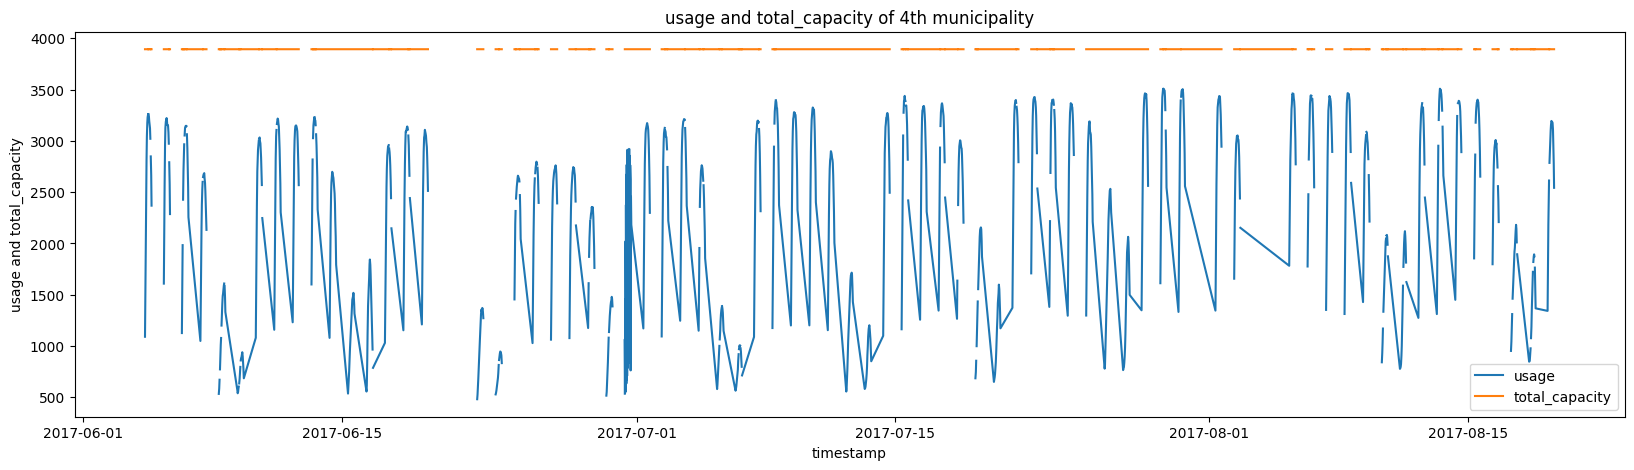

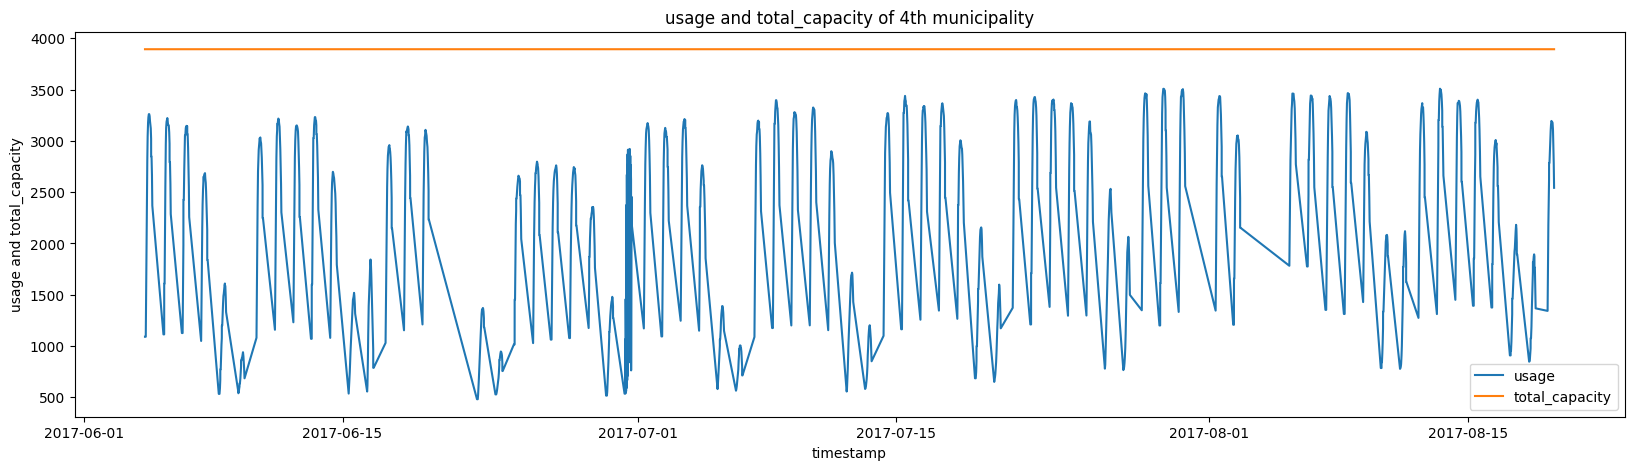

In [119]:
selected_municipality_id = 4

# plot usage and show missing values in 4th municipality
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(expanded_df[expanded_df['municipality_id'] == selected_municipality_id]['usage'], label='usage')
ax.plot(expanded_df[expanded_df['municipality_id'] == selected_municipality_id]['total_capacity'], label='total_capacity')
ax.legend()
ax.set_title('usage and total_capacity of 4th municipality')
ax.set_xlabel('timestamp')
ax.set_ylabel('usage and total_capacity')
plt.show()

# impute missing values for each municipality
imputed_df = expanded_df.copy()
for municipality_id in imputed_df['municipality_id'].unique():
    # fill total_capacity with max value
    imputed_df.loc[imputed_df['municipality_id'] == municipality_id, 'total_capacity'] = imputed_df[imputed_df['municipality_id'] == municipality_id]['total_capacity'].fillna(imputed_df[imputed_df['municipality_id'] == municipality_id]['total_capacity'].max())

    # fill usage with interpolation that is best appropriate of method
    imputed_df.loc[imputed_df['municipality_id'] == municipality_id, 'usage'] = imputed_df[imputed_df['municipality_id'] == municipality_id]['usage'].fillna(method='bfill')

# plot usage and show missing values in 4th municipality
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(imputed_df[imputed_df['municipality_id'] == selected_municipality_id]['usage'], label='usage')
ax.plot(imputed_df[imputed_df['municipality_id'] == selected_municipality_id]['total_capacity'], label='total_capacity')
ax.legend()
ax.set_title('usage and total_capacity of 4th municipality')
ax.set_xlabel('timestamp')
ax.set_ylabel('usage and total_capacity')
plt.show()



In [120]:
df = imputed_df.copy()

## Preprocessing

In [123]:
# split data to train and test set
horizon = pd.to_datetime("2017-08-05")

train = df.loc[df["date"] < horizon]
test = df.loc[df["date"] >= horizon]

print(f"Shape of Dataframe: {df.shape}")
print(f"Shape of Train Set: {train.shape}")
print(f"Shape of Test Set: {test.shape}")

Shape of Dataframe: (14430, 10)
Shape of Train Set: (11380, 10)
Shape of Test Set: (3050, 10)


## Model Development

### Forecast with XGBoost

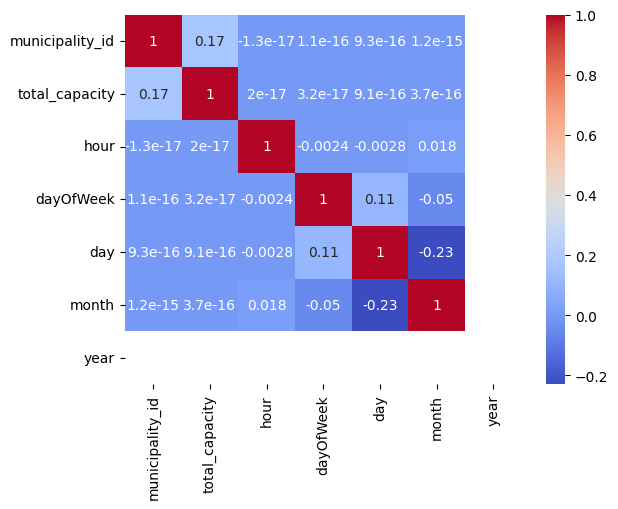

In [210]:
FEATURES = ['municipality_id', 'total_capacity', 'hour', 'dayOfWeek', 'day', 'month', 'year']
TARGET = 'usage'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# check the correlation between features
corr = X_train.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [225]:
#  xgboost model for each municipality
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import xgboost as xgb

regressor = xgb.XGBRegressor(n_estimators=10000, learning_rate=0.001, n_jobs=7, random_state=42)
regressor.fit(X_train, y_train,
              early_stopping_rounds=50,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100)


[0]	validation_0-rmse:1087.15582	validation_1-rmse:1181.07973
[100]	validation_0-rmse:988.26183	validation_1-rmse:1081.54436
[200]	validation_0-rmse:899.13901	validation_1-rmse:992.04616
[300]	validation_0-rmse:818.83310	validation_1-rmse:911.22889
[400]	validation_0-rmse:746.54703	validation_1-rmse:838.59205
[500]	validation_0-rmse:681.76306	validation_1-rmse:773.04081
[600]	validation_0-rmse:623.54094	validation_1-rmse:714.15556
[700]	validation_0-rmse:571.26625	validation_1-rmse:661.42292
[800]	validation_0-rmse:524.31993	validation_1-rmse:614.34770
[900]	validation_0-rmse:482.27544	validation_1-rmse:572.26893
[1000]	validation_0-rmse:444.88212	validation_1-rmse:534.85509
[1100]	validation_0-rmse:411.55489	validation_1-rmse:501.27088
[1200]	validation_0-rmse:381.82275	validation_1-rmse:471.32631
[1300]	validation_0-rmse:354.63212	validation_1-rmse:444.75313
[1400]	validation_0-rmse:330.43772	validation_1-rmse:421.20337
[1500]	validation_0-rmse:309.08074	validation_1-rmse:400.17777
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=7, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

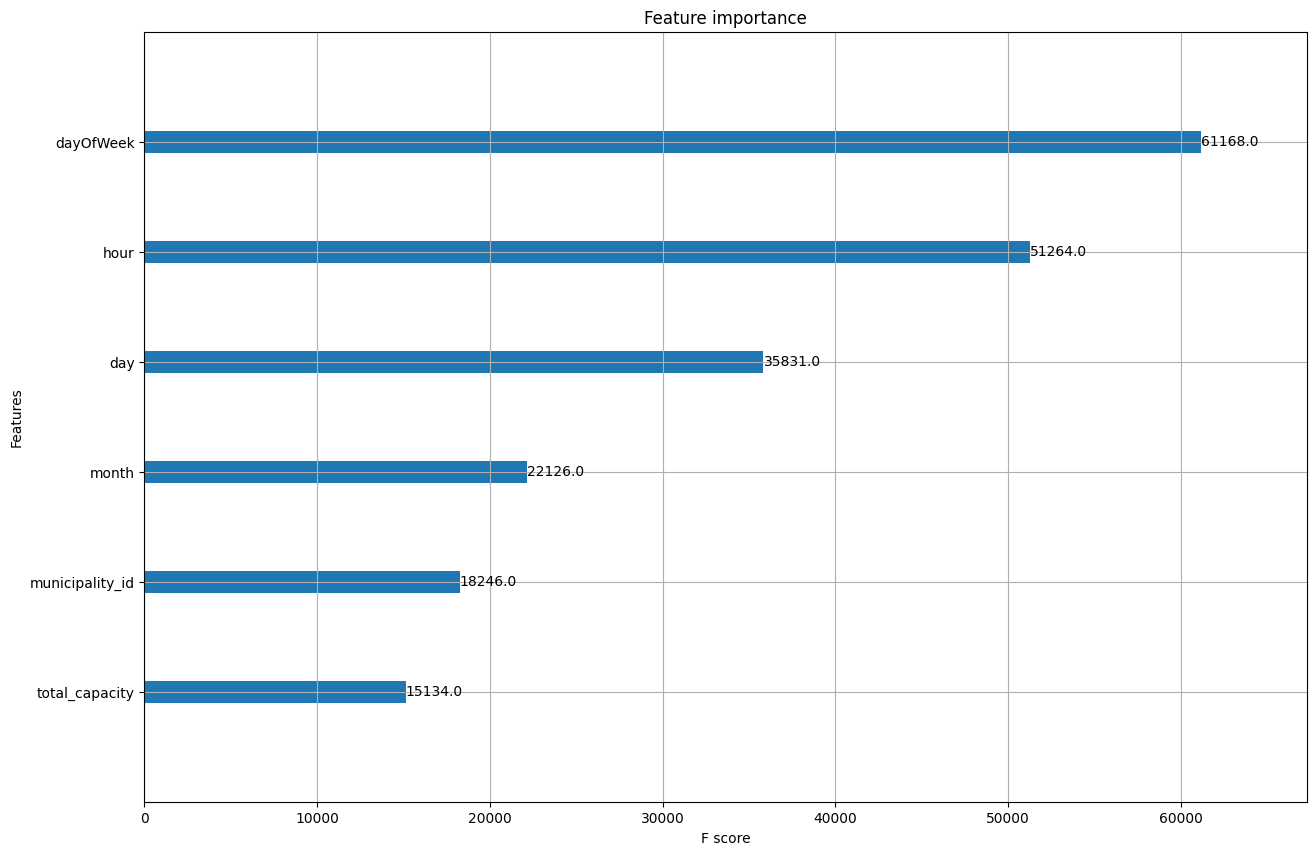

In [227]:
# plot feature importance
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(regressor, ax=ax)
plt.show()


#### Forecast on Test Set

In [228]:
test['prediction'] = regressor.predict(X_test)
df = df.merge(test[['prediction']], left_index=True, right_index=True, how='left')

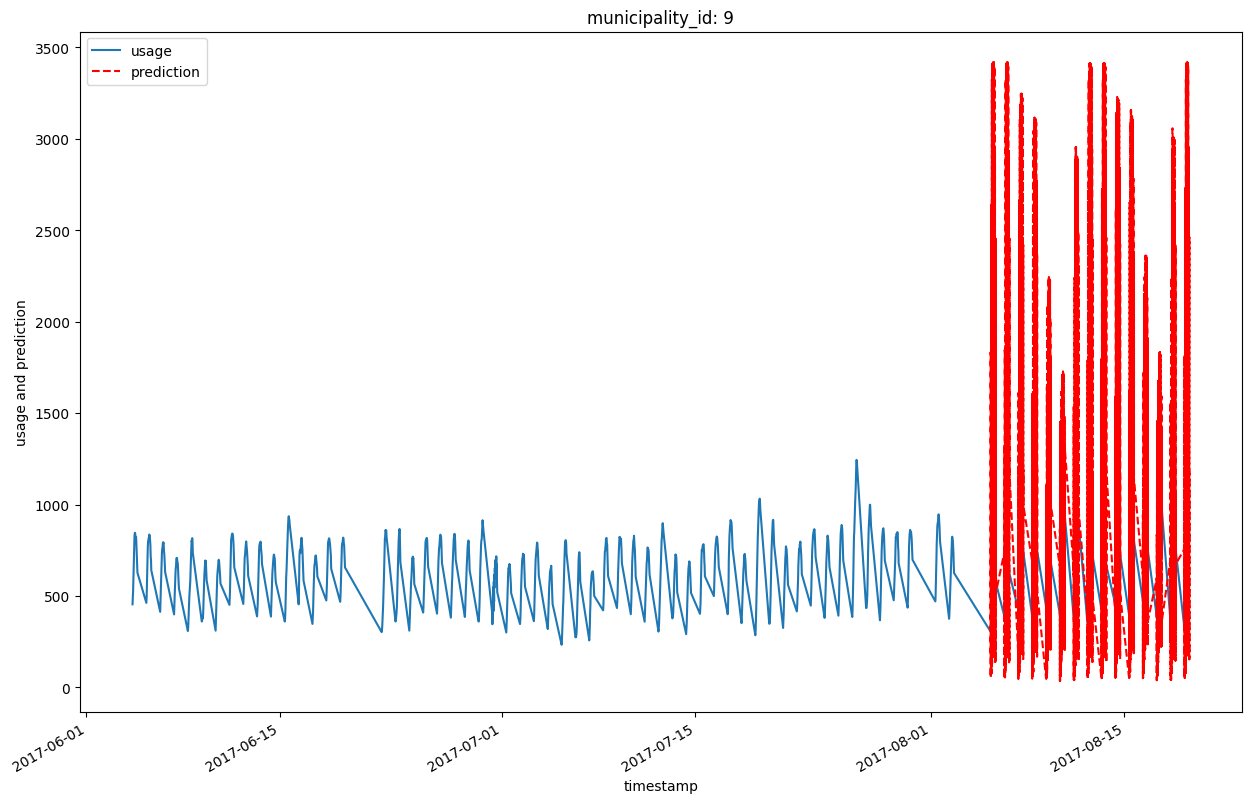

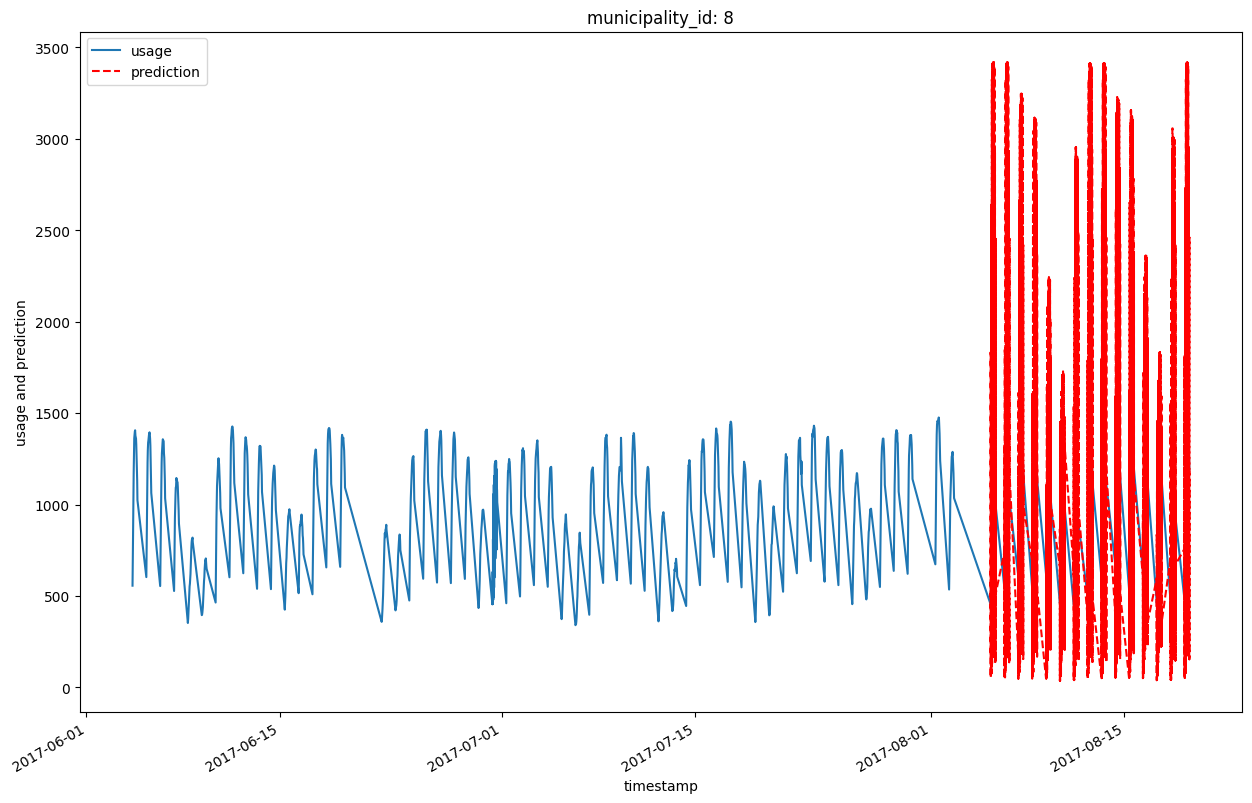

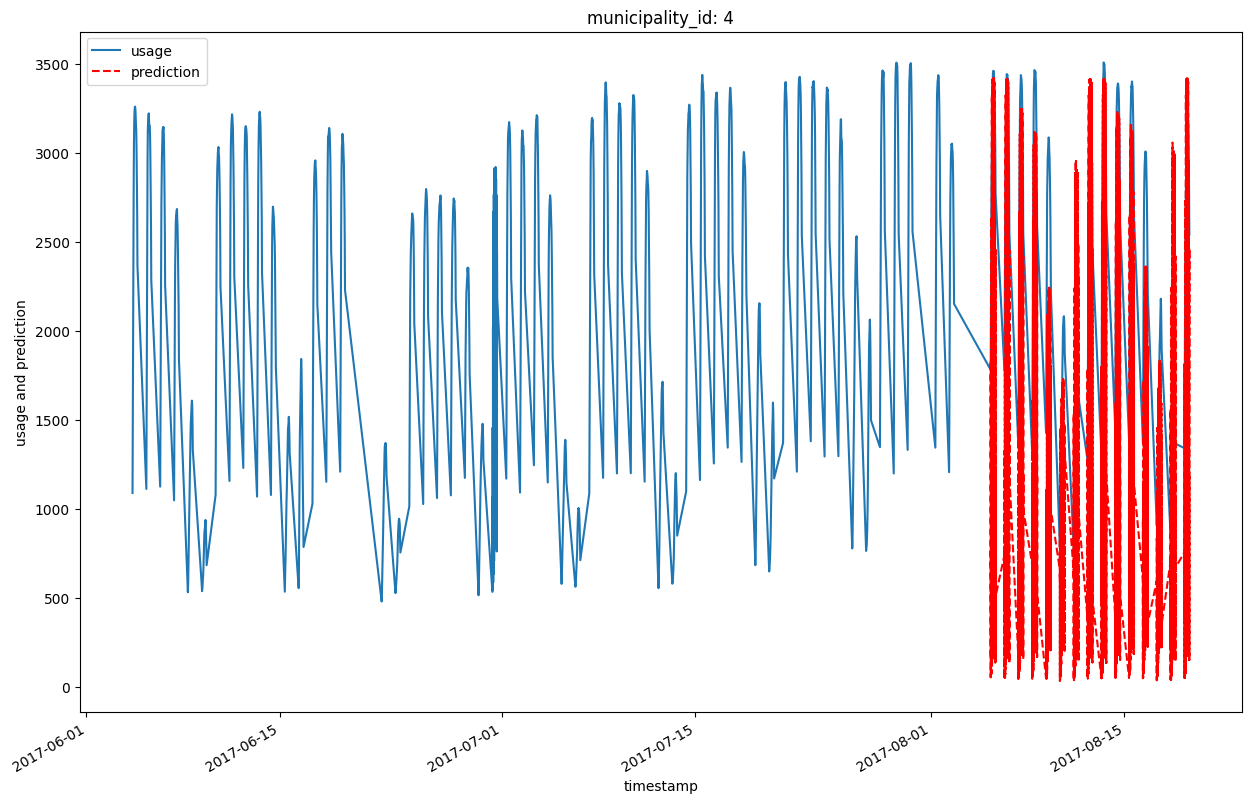

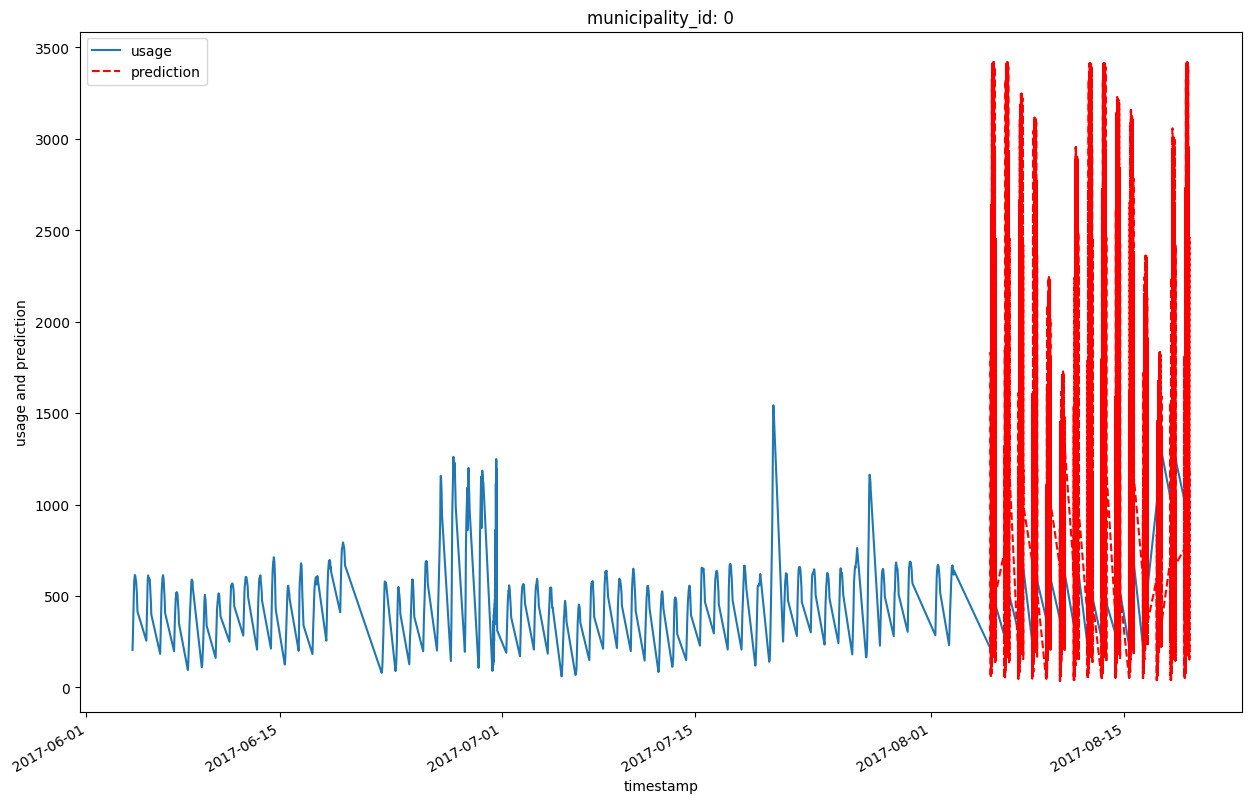

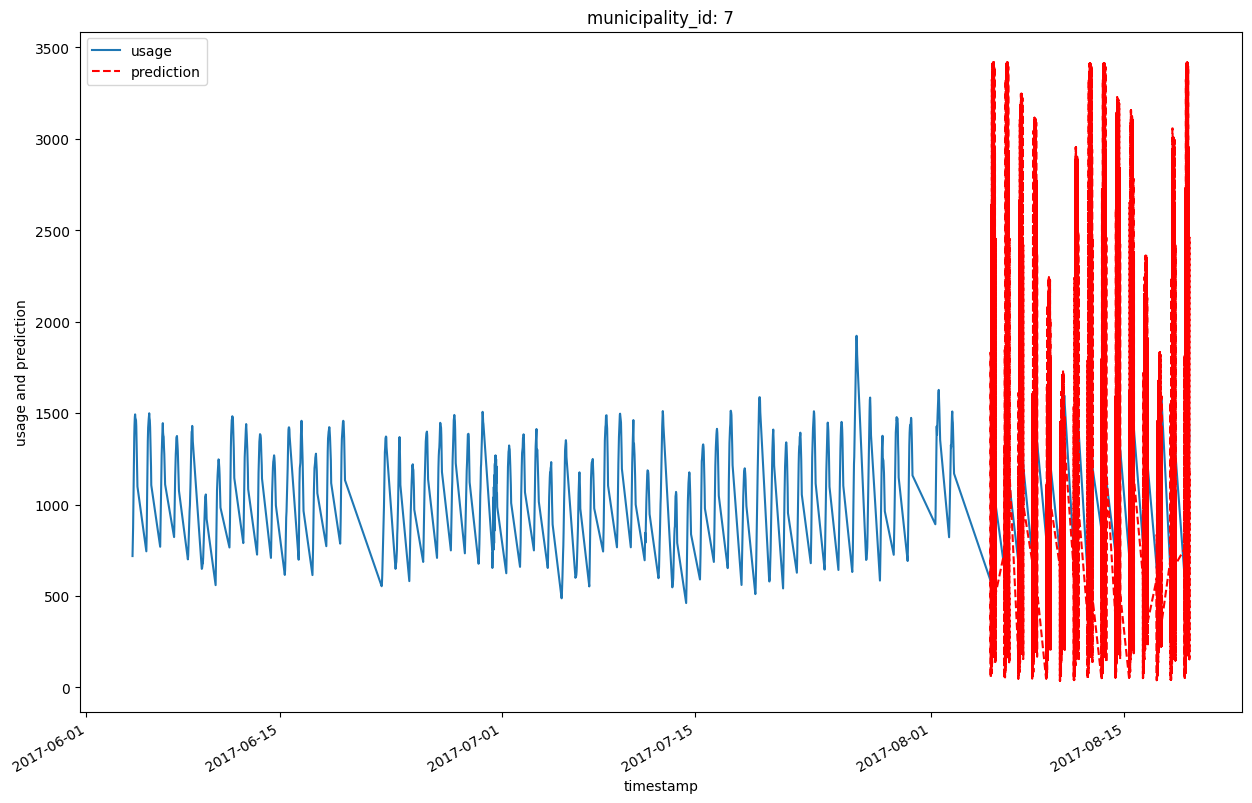

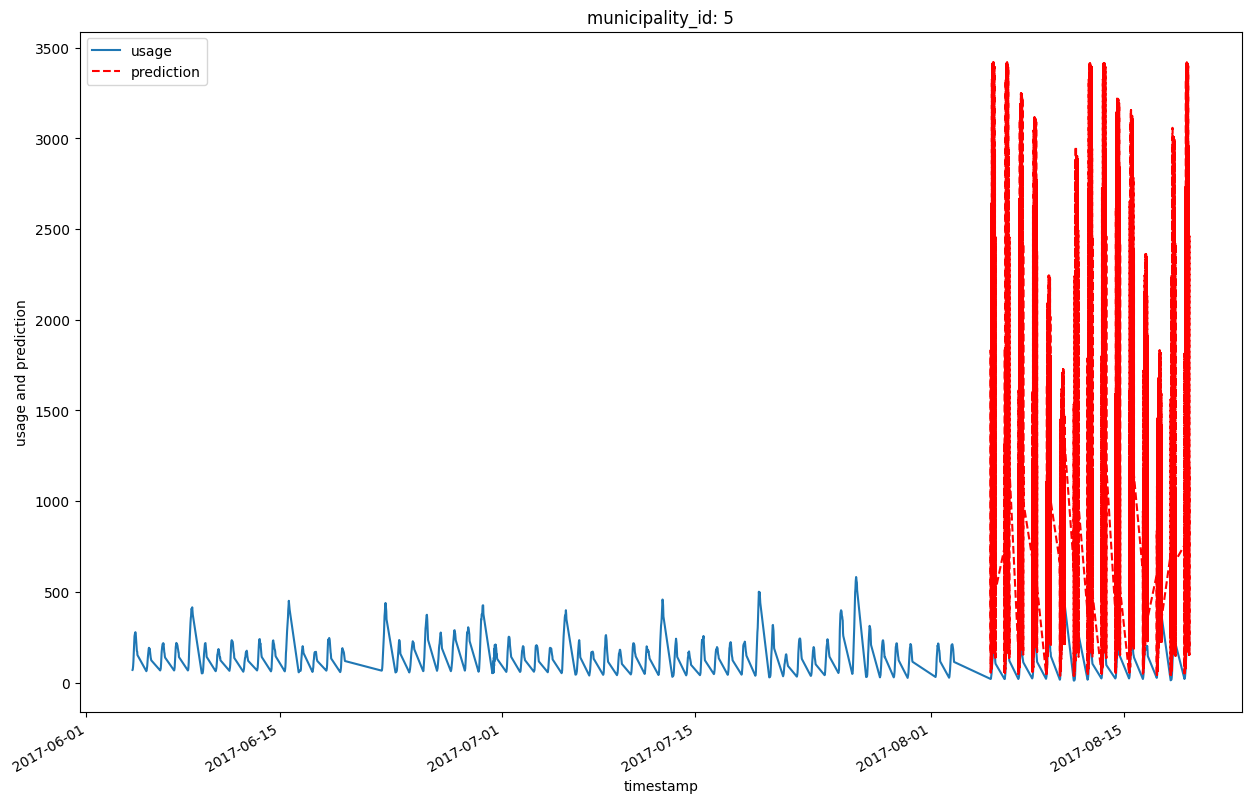

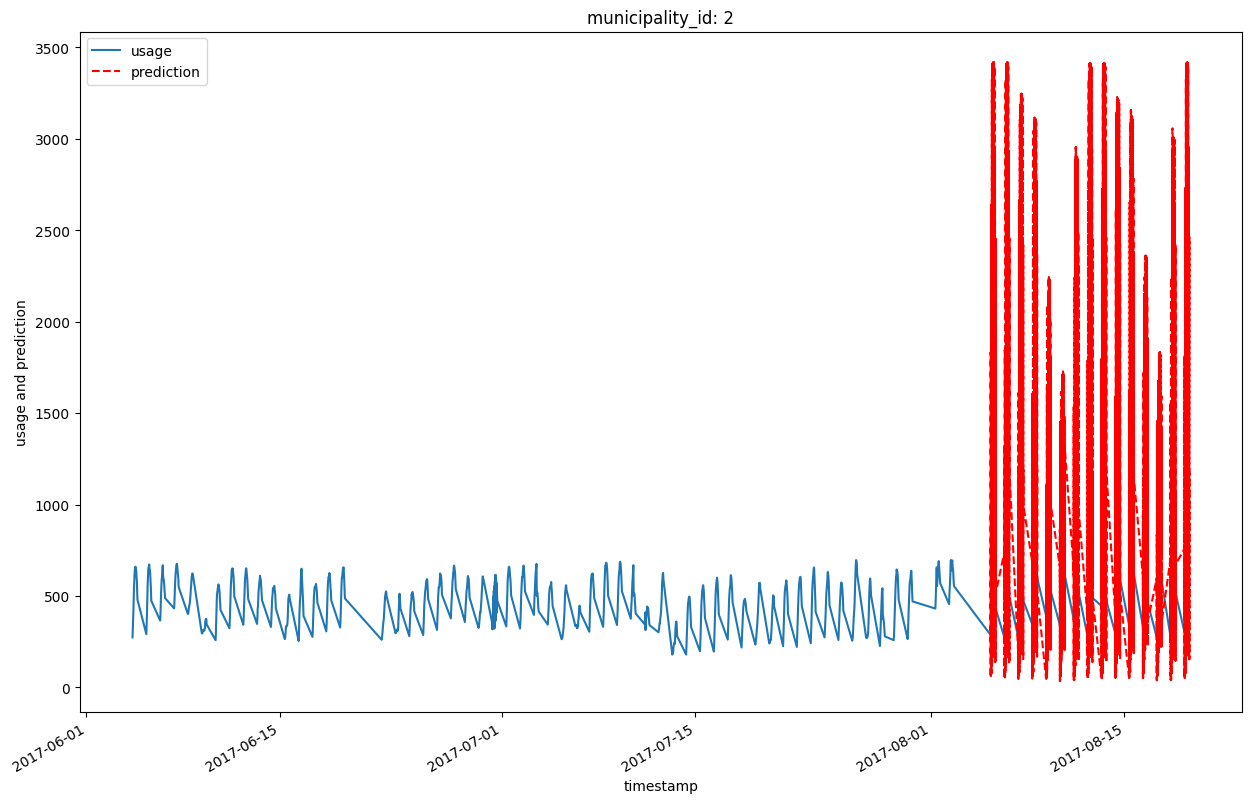

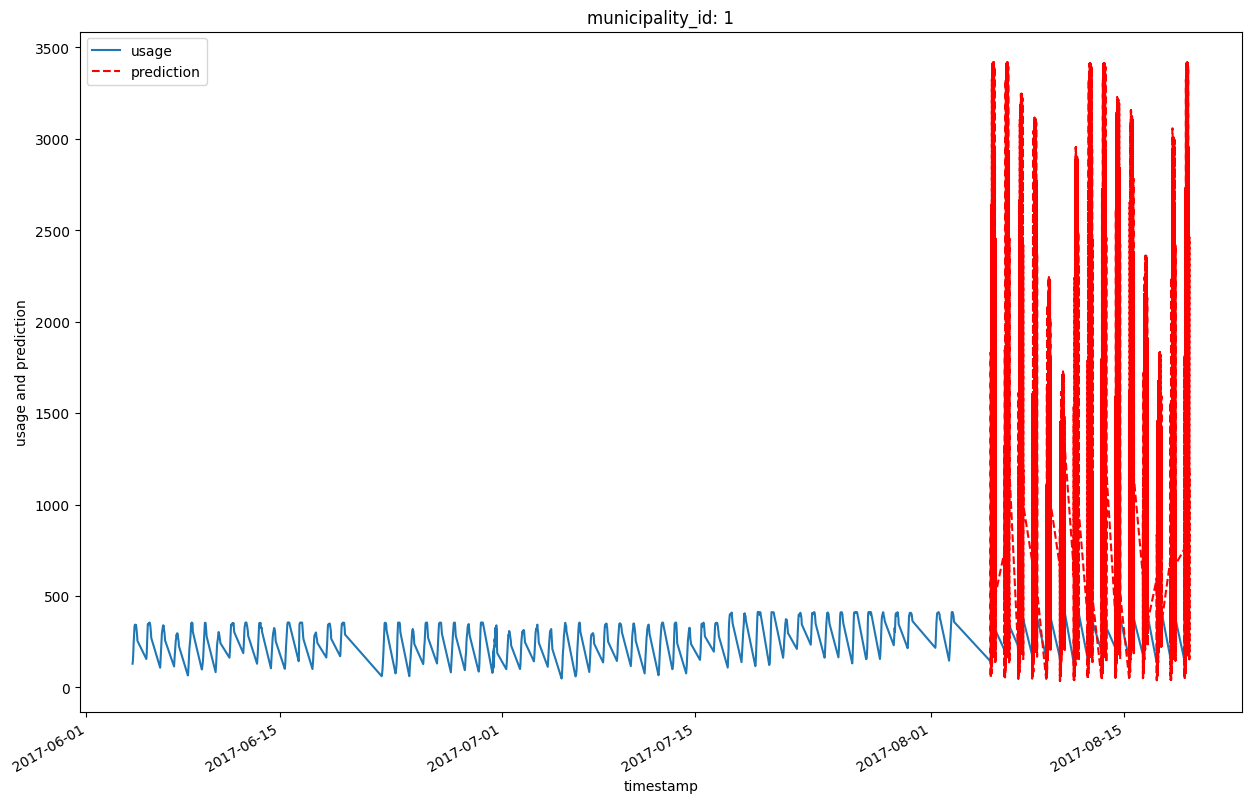

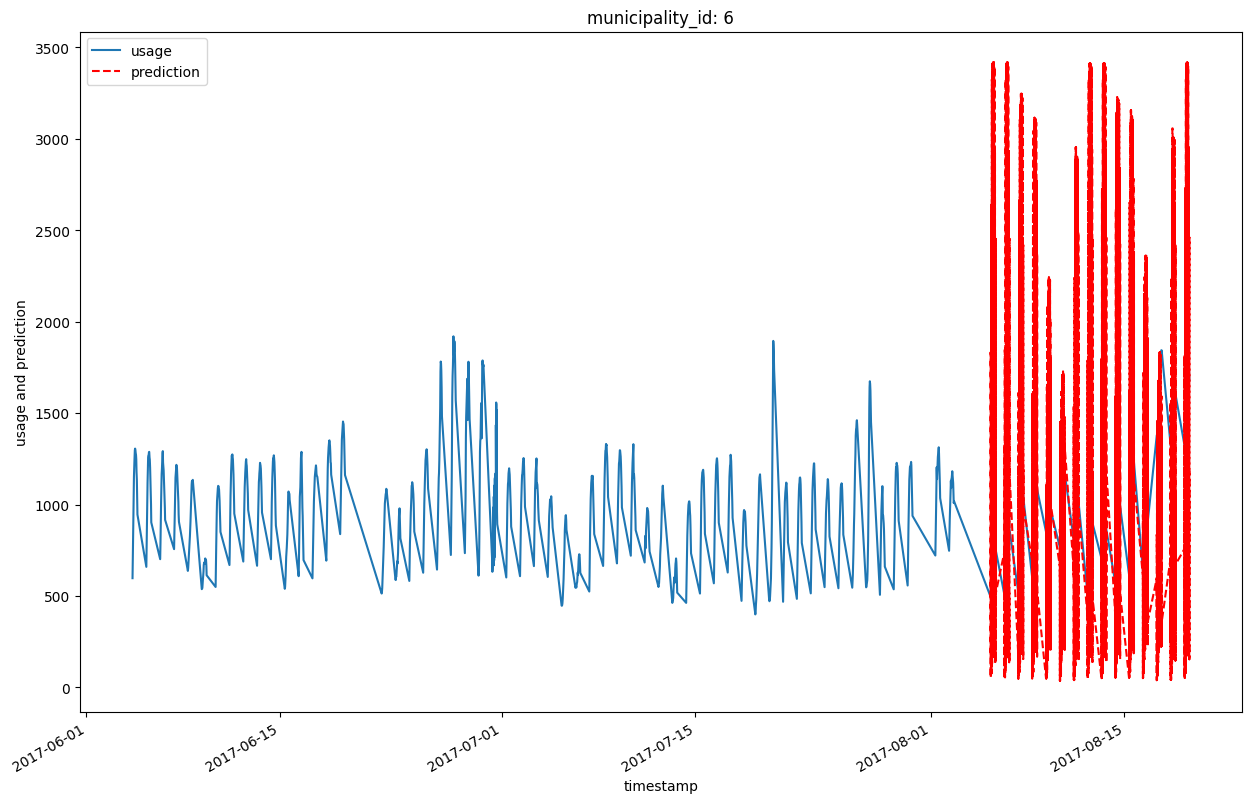

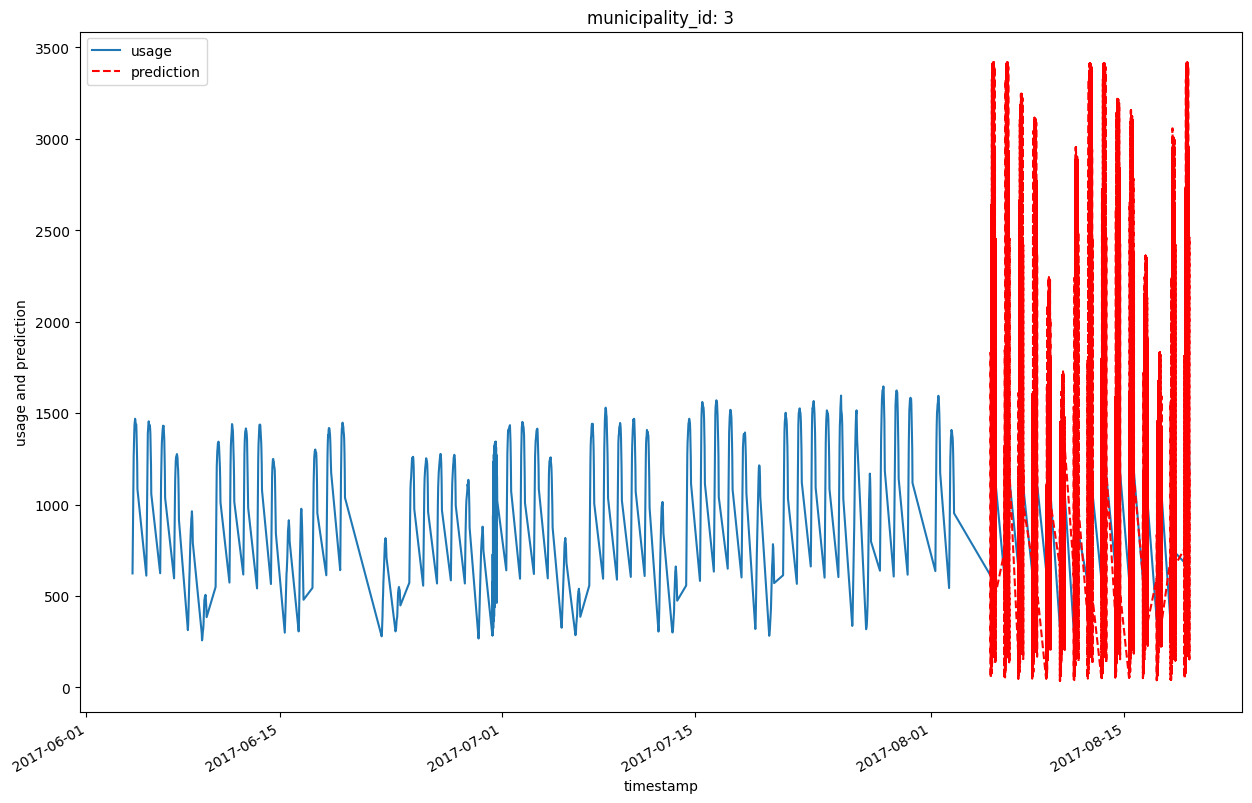

In [236]:
for municipality_id in df['municipality_id'].unique():
    fig, ax = plt.subplots(figsize=(15, 10))
    df[df['municipality_id'] == municipality_id]['usage'].plot(ax=ax, label='usage')
    df[df['municipality_id'] == municipality_id]['prediction'].plot(ax=ax, label='prediction', color='red', linestyle='--')
    ax.set_xlabel('timestamp')
    ax.set_ylabel('usage and prediction')
    ax.set_title(f"municipality_id: {municipality_id}")
    ax.legend()
    plt.show()

## Forecast with Prophet

04:03:47 - cmdstanpy - INFO - Chain [1] start processing
04:03:47 - cmdstanpy - INFO - Chain [1] done processing


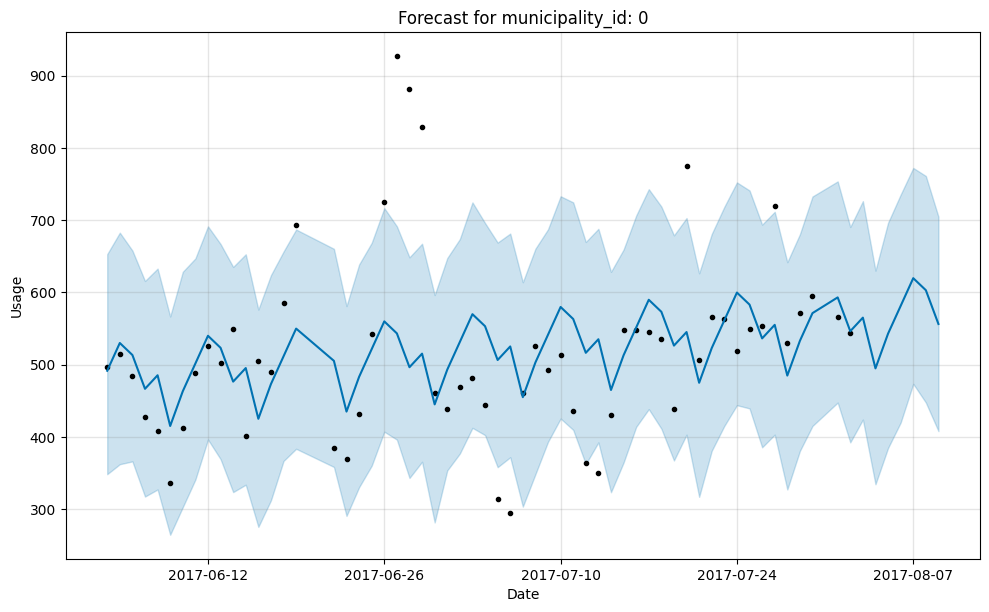

In [77]:
# Forecasting to the next week (7 days) for each municipality_id using Prophet model
from prophet import Prophet

# create a function to forecast the next week (7 days) for each municipality_id
def forecast_next_week(df, municipality_id):
    # filter data by municipality_id
    df = df[df['municipality_id'] == municipality_id]
    # drop municipality_id column
    df.drop('municipality_id', axis=1, inplace=True)
    # group by date and aggregate the mean of usage and total_capacity
    df = df.groupby('date').agg({'usage': 'mean', 'total_capacity': 'mean'})
    # convert index to column
    df = df.reset_index()
    # rename columns
    df = df.rename(columns={'date': 'ds', 'usage': 'y'})
    # create Prophet model
    model = Prophet()
    # fit the model
    model.fit(df)
    # create future dataframe with 7 days
    future = model.make_future_dataframe(periods=7, freq='D')
    # forecast the next week (7 days)
    forecast = model.predict(future)
    # plot the forecast
    model.plot(forecast)
    plt.title(f"Forecast for municipality_id: {municipality_id}")
    plt.xlabel("Date")
    plt.ylabel("Usage")
    plt.show()
    return forecast

# forecast the next week (7 days) for each municipality_id
forecast = forecast_next_week(train, 0)


In [75]:
# Forecasting to the next week (7 days) for each municipality_id and hour using SARIMAX model

# import libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX

# create a function to forecast the next week (7 days) for each municipality_id and hour
def forecast_sarimax(df, municipality_id):
    df = df.loc[df['municipality_id'] == municipality_id]
    
    # group by date and hour and aggregate the mean of usage and total_capacity
    df = df.groupby(['date', 'hour']).agg({'usage': 'mean', 'total_capacity': 'mean'}).reset_index()
    
    # set date and hour as index
    df = df.set_index(['date', 'hour'])
    
    # create SARIMAX model
    model = SARIMAX(df['usage'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
    model_fit = model.fit()
    
    # forecast the next week (7 days)
    forecast = model_fit.predict(start=df.shape[0], end=df.shape[0]+167)
    
    # convert forecast to dataframe
    forecast = pd.DataFrame(forecast, columns=['usage'])
    forecast = forecast.reset_index()
    
    # convert date and hour to timestamp
    forecast['timestamp'] = pd.to_datetime(forecast['date'].astype(str) + ' ' + forecast['hour'].astype(str), format='%Y-%m-%d %H')
    
    # drop date and hour
    forecast.drop(['date', 'hour'], axis=1, inplace=True)
    
    # set timestamp as index
    forecast = forecast.set_index('timestamp')
    return forecast

# create a function to plot the forecasted usage for each municipality_id
def plot_forecast_sarimax(df, municipality_id):
    forecast = forecast_sarimax(df, municipality_id)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(df[df['municipality_id'] == municipality_id]['date'], df[df['municipality_id'] == municipality_id]['usage'], label='usage')
    ax.plot(forecast.index, forecast['usage'], label='forecast')
    ax.set_xlabel('date')
    ax.set_ylabel('usage')
    ax.set_title(f'Forecasted usage for municipality_id: {municipality_id}')
    ax.legend()
    plt.show()

# plot the forecasted usage for each municipality_id
for i in range(10):
    plot_forecast_sarimax(train, i)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40068D+00    |proj g|=  7.33925D-02


 This problem is unconstrained.



At iterate    5    f=  6.35568D+00    |proj g|=  1.24603D-02

At iterate   10    f=  6.35474D+00    |proj g|=  4.51480D-03

At iterate   15    f=  6.32604D+00    |proj g|=  9.73923D-02

At iterate   20    f=  6.25654D+00    |proj g|=  9.27422D-03

At iterate   25    f=  6.25463D+00    |proj g|=  6.49101D-04

At iterate   30    f=  6.25156D+00    |proj g|=  1.93951D-02

At iterate   35    f=  6.24986D+00    |proj g|=  6.88603D-05

At iterate   40    f=  6.24985D+00    |proj g|=  7.66968D-04
  ys=-2.915E-04  -gs= 8.258E-05 BFGS update SKIPPED

At iterate   45    f=  6.24864D+00    |proj g|=  3.44108D-03

At iterate   50    f=  6.24705D+00    |proj g|=  1.43024D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

KeyError: 'date'